In [23]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
from skimage import data_dir
from skimage.transform import resize
import time
import cv2

In [24]:
noise_var = np.logspace(0, 2, 5)

barbara = cv2.imread("barbara.png").astype(np.float) / 255.0
barbara = resize(barbara, (barbara.shape[0]/2, barbara.shape[1]/2))
barbara = color.rgb2lab(barbara)
barbara = barbara[:,:,0]

noisy = []
for sigma2 in noise_var:
    noise = np.random.normal(0, np.sqrt(sigma2), barbara.shape)
    n = barbara + noise
    # avoid going over bounds
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)

/Users/sanketh/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sanketh/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


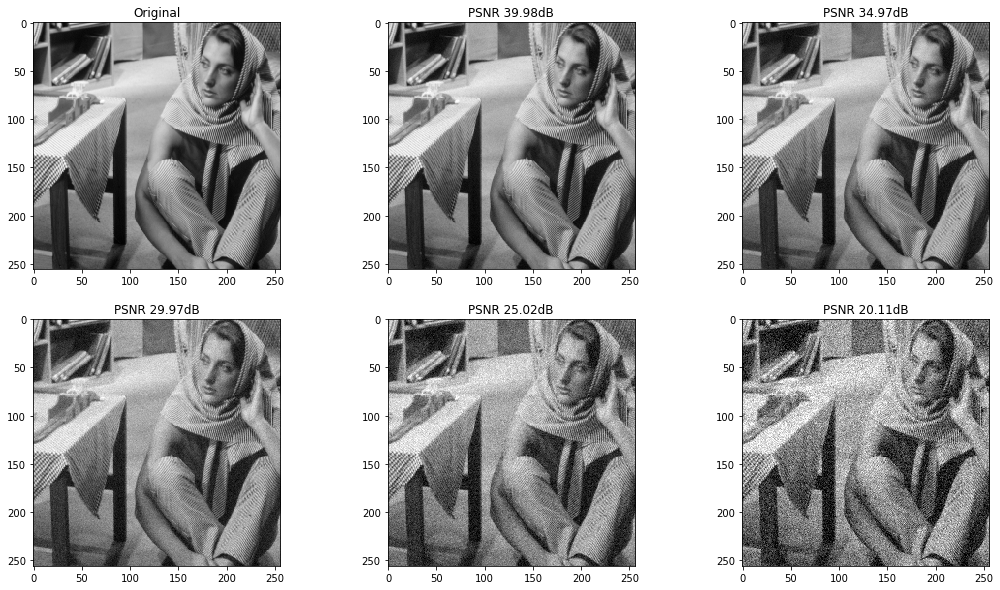

In [25]:
def PSNR(original, noisy, peak=100):
    mse = np.mean((original-noisy)**2)
    return 10*np.log10(peak*peak/mse)

plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.imshow(barbara,cmap='gray')
plt.title("Original")
for i,n in enumerate(noisy):
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.2f}dB".format(PSNR(barbara, n)))
    plt.imshow(n,cmap='gray')

In [17]:
from functools import reduce, partial 

def _distance(values, pixel_window, h2, Nw):
    patch_window, central_diff = values

    diff = np.sum((pixel_window - patch_window) ** 2)
    # remove the central distance from the computation
    diff -= central_diff

    w = np.exp(-diff / (h2 * Nw))

    # return the color of the pixel and the weight associated with the patch
    nr, nc = patch_window.shape
    return w * patch_window[nr // 2, nc // 2], w

def nonlocalmeans_naive(img, n_big=20, n_small=5, h=10):
    new_n = np.zeros_like(img)

    Nw = (2 * n_small + 1) ** 2
    h2 = h * h
    n_rows, n_cols = img.shape

    # precompute the coordinate difference for the big patch
    D = range(-n_big, n_big + 1)
    big_diff = [(r, c) for r in D for c in D if not (r == 0 and c == 0)]

    # precompute coordinate difference for the small patch
    small_rows, small_cols = np.indices((2 * n_small + 1, 2 * n_small + 1)) - n_small

    padding = n_big + n_small
    n_padded = np.pad(img, padding, mode='reflect')

    for r in range(padding, padding + n_rows):
        for c in range(padding, padding + n_cols):
            pixel_window = n_padded[small_rows + r, small_cols + c]

            # construct a list of patch_windows
            windows = [n_padded[small_rows + r + d[0], small_cols + c + d[1]] for d in big_diff]

            # construct a list of central differences
            central_diffs = [(n_padded[r, c] - n_padded[r + d[0], c + d[1]]) for d in big_diff]

            distance_map = partial(_distance, pixel_window=pixel_window, h2=h2, Nw=Nw)
            distances = map(distance_map, zip(windows, central_diffs))

            total_c, total_w = reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), distances)
            new_n[r - padding, c - padding] = total_c / total_w

    return new_n

In [18]:
def estimate_noise(img):
    upper = img[:-2, 1:-1].flatten()
    lower = img[2:, 1:-1].flatten()
    left = img[1:-1, :-2].flatten()
    right = img[1:-1, 2:].flatten()
    central = img[1:-1, 1:-1].flatten()
    U = np.column_stack((upper, lower, left, right))
    c_estimated = np.dot(U, np.dot(np.linalg.pinv(U), central))
    error = np.mean((central - c_estimated)**2)
    sigma = np.sqrt(error)
    return sigma

In [26]:
sigmas = []
for i,n in enumerate(noisy):
    sigma = estimate_noise(n)
    sigmas.append(sigma)
    print("Estimated noise is {0:.4f}, real noise is {1:.4f}".format(sigma, np.sqrt(noise_var[i])))
    

Estimated noise is 4.8003, real noise is 1.0000
Estimated noise is 5.1079, real noise is 1.7783
Estimated noise is 6.0119, real noise is 3.1623
Estimated noise is 8.0070, real noise is 5.6234
Estimated noise is 12.1500, real noise is 10.0000


KeyboardInterrupt: 

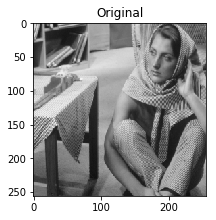

In [27]:
denoised_naive = []
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(barbara, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nonlocalmeans_naive(noisy[2], n_big=7, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_naive.append(denoised)
    oPSNR = PSNR(barbara, noisy[i])
    dPSNR = PSNR(barbara, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - took {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')


In [28]:
from sklearn.decomposition import PCA
from sklearn.neighbors.ball_tree import BallTree

def nonlocalmeans_clustered(img, n_small=5, n_components=9, n_neighbors=30, h=10):

    Nw = (2 * n_small + 1) ** 2
    h2 = h * h
    n_rows, n_cols = img.shape

    # precompute the coordinate difference for the big patch
    small_rows, small_cols = np.indices(((2 * n_small + 1), (2 * n_small + 1))) - n_small

    # put all patches so we can cluster them
    n_padded = np.pad(img, n_small, mode='reflect')
    patches = np.zeros((n_rows * n_cols, Nw))

    n = 0
    for r in range(n_small, n_small + n_rows):
        for c in range(n_small, n_small + n_cols):
            window = n_padded[r + small_rows, c + small_cols].flatten()
            patches[n, :] = window
            n += 1

    transformed = PCA(n_components=n_components).fit_transform(patches)
    print(transformed.shape)
    # index the patches into a tree
    tree = BallTree(transformed, leaf_size=2)

    new_img = np.zeros_like(img)
    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            #print(transformed[idx])
            _, ind = tree.query(np.expand_dims(transformed[idx],0), k=n_neighbors)
            ridx = np.array([(int(i / n_cols), int(i % n_cols)) for i in ind[0, 1:]])
            colors = img[ridx[:, 0], ridx[:, 1]]
            # compute real patch distances
            dist = [np.mean((patches[i] - patches[idx])**2) for i in ind[0, 1:]]
            w = np.exp(-np.array(dist) / h2)
            new_img[r, c] = np.sum(w * colors) / np.sum(w)

    return new_img

(65536, 9)
PSNR before 39.9540 - PSNR after denoising 31.8144 - tool 53.8 secs
(65536, 9)
PSNR before 35.0151 - PSNR after denoising 31.8104 - tool 53.8 secs
(65536, 9)
PSNR before 30.0244 - PSNR after denoising 31.8015 - tool 53.6 secs
(65536, 9)
PSNR before 25.0052 - PSNR after denoising 31.7911 - tool 53.8 secs
(65536, 9)
PSNR before 20.1530 - PSNR after denoising 31.7837 - tool 53.4 secs


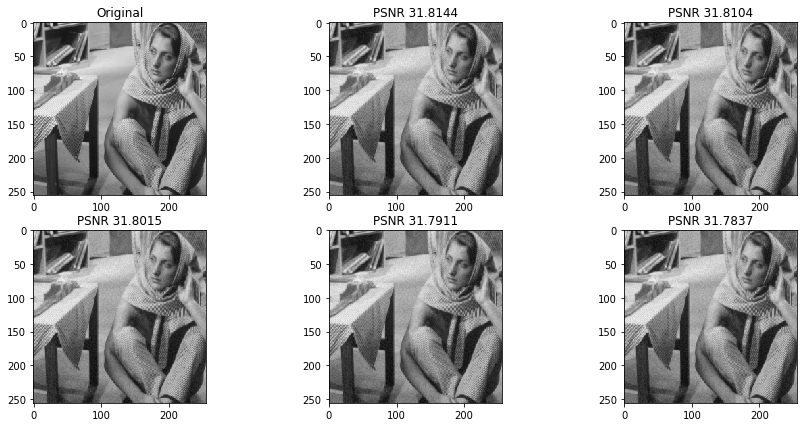

In [22]:
denoised_clustered = []
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(barbara, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nonlocalmeans_clustered(noisy[2], n_neighbors=30, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_clustered.append(denoised)
    oPSNR = PSNR(barbara, noisy[i])
    dPSNR = PSNR(barbara, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - took {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')